In [25]:
!pip install airportsdata pycountry
!pip install haversine

In [26]:
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import airportsdata
from haversine import haversine, Unit

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Load the dataset

In [27]:
df_sessions_base= pd.read_csv('travel_tide_dataset.csv')
df_sessions_base.head()

,session_id,user_id,birthdate,gender,married,has_children,home_country,home_city,home_airport,home_airport_lat,...,destination_airport_lat,destination_airport_lon,base_fare_usd,hotel_name,hotel_location,nights,rooms,check_in_time,check_out_time,hotel_per_room_usd
0,491617-feb5c48e5f874e708602706d4ea74d51,491617,1970-10-12,F,False,False,canada,hamilton,YHM,43.173,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,499366-8b81f36216b34894be8838fb224ac162,499366,1976-01-04,F,False,False,canada,quebec,YQB,46.788,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,510094-b55030adcc7e49afbef15304ea4d2167,510094,1978-07-08,F,False,False,usa,long beach,LGB,33.818,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,513322-ba930ad2186d4169bc51f5c11af0ccdd,513322,1973-01-04,F,False,False,usa,new york,LGA,40.777,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,521295-3c53ea4d476e4057b2460b011f44722b,521295,1983-03-08,F,False,True,usa,baton rouge,BTR,30.533,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
df_sessions_base.shape

(49211, 42)

In [29]:
# Get the IDs of canceled trips
df_canceled_trips = df_sessions_base[df_sessions_base['cancellation'] == True]['trip_id'].drop_duplicates()
df_canceled_trips.head()

,trip_id
7351,513807-3c80157290d341feac1def60567b019c
11347,454934-2b0809d98c0a466ab8f1502d8c229ffc
13465,498500-8625a588e269412d9c6ac9ddbbb19a9d
15548,520861-df209855e39a4b3c93cc547763a87ea2
15549,733654-777d480b8d09486189720f37e154f60c


In [30]:
# Create a table for only booked trips
df_booked_trips = df_sessions_base[~df_sessions_base['trip_id'].isin(df_canceled_trips)]
df_booked_trips.head()

,session_id,user_id,birthdate,gender,married,has_children,home_country,home_city,home_airport,home_airport_lat,...,destination_airport_lat,destination_airport_lon,base_fare_usd,hotel_name,hotel_location,nights,rooms,check_in_time,check_out_time,hotel_per_room_usd
0,491617-feb5c48e5f874e708602706d4ea74d51,491617,1970-10-12,F,False,False,canada,hamilton,YHM,43.173,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,499366-8b81f36216b34894be8838fb224ac162,499366,1976-01-04,F,False,False,canada,quebec,YQB,46.788,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,510094-b55030adcc7e49afbef15304ea4d2167,510094,1978-07-08,F,False,False,usa,long beach,LGB,33.818,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,513322-ba930ad2186d4169bc51f5c11af0ccdd,513322,1973-01-04,F,False,False,usa,new york,LGA,40.777,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,521295-3c53ea4d476e4057b2460b011f44722b,521295,1983-03-08,F,False,True,usa,baton rouge,BTR,30.533,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
df_booked_trips.shape

(47998, 42)

# EDA on Session level

In [32]:
df_booked_trips.shape

(47998, 42)

In [33]:
df_booked_trips.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47998 entries, 0 to 49210
Data columns (total 42 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   session_id               47998 non-null  object 
 1   user_id                  47998 non-null  int64  
 2   birthdate                47998 non-null  object 
 3   gender                   47998 non-null  object 
 4   married                  47998 non-null  bool   
 5   has_children             47998 non-null  bool   
 6   home_country             47998 non-null  object 
 7   home_city                47998 non-null  object 
 8   home_airport             47998 non-null  object 
 9   home_airport_lat         47998 non-null  float64
 10  home_airport_lon         47998 non-null  float64
 11  sign_up_date             47998 non-null  object 
 12  trip_id                  15489 non-null  object 
 13  session_start            47998 non-null  object 
 14  session_end              47

In [34]:
df_booked_trips['home_country'].value_counts()

,count
home_country,
usa,39991
canada,8007


## Anomaly detection

In [35]:
df_booked_trips.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,47998.0,545394.154006,64164.528789,23557.000,517169.750,540260.000,573719.000,844489.000
home_airport_lat,47998.0,38.416751,6.183617,21.316,33.818,39.103,42.238,61.251
home_airport_lon,47998.0,-94.182541,18.052939,-157.927,-112.383,-90.035,-79.370,-63.499
flight_discount_amount,8189.0,0.139871,0.083864,0.050,0.100,0.100,0.200,0.600
hotel_discount_amount,6118.0,0.112365,0.062281,0.050,0.050,0.100,0.150,0.450
page_clicks,47998.0,15.471207,12.954254,1.000,6.000,12.000,21.000,279.000
seats,13157.0,1.183324,0.519154,1.000,1.000,1.000,1.000,8.000
checked_bags,13157.0,0.571179,0.635464,0.000,0.000,1.000,1.000,8.000
destination_airport_lat,13157.0,38.800186,6.254131,-37.008,33.942,39.872,42.364,55.972
destination_airport_lon,13157.0,-92.239693,23.645144,-157.927,-112.383,-87.752,-75.669,174.792


**We can see some -ve values in nights.** This is an anomaly and needs to be handled. The -ve value in destination_airport_lon is acceptable.

We also see an unusual page_click max amount (111). This needs to be investigated further.

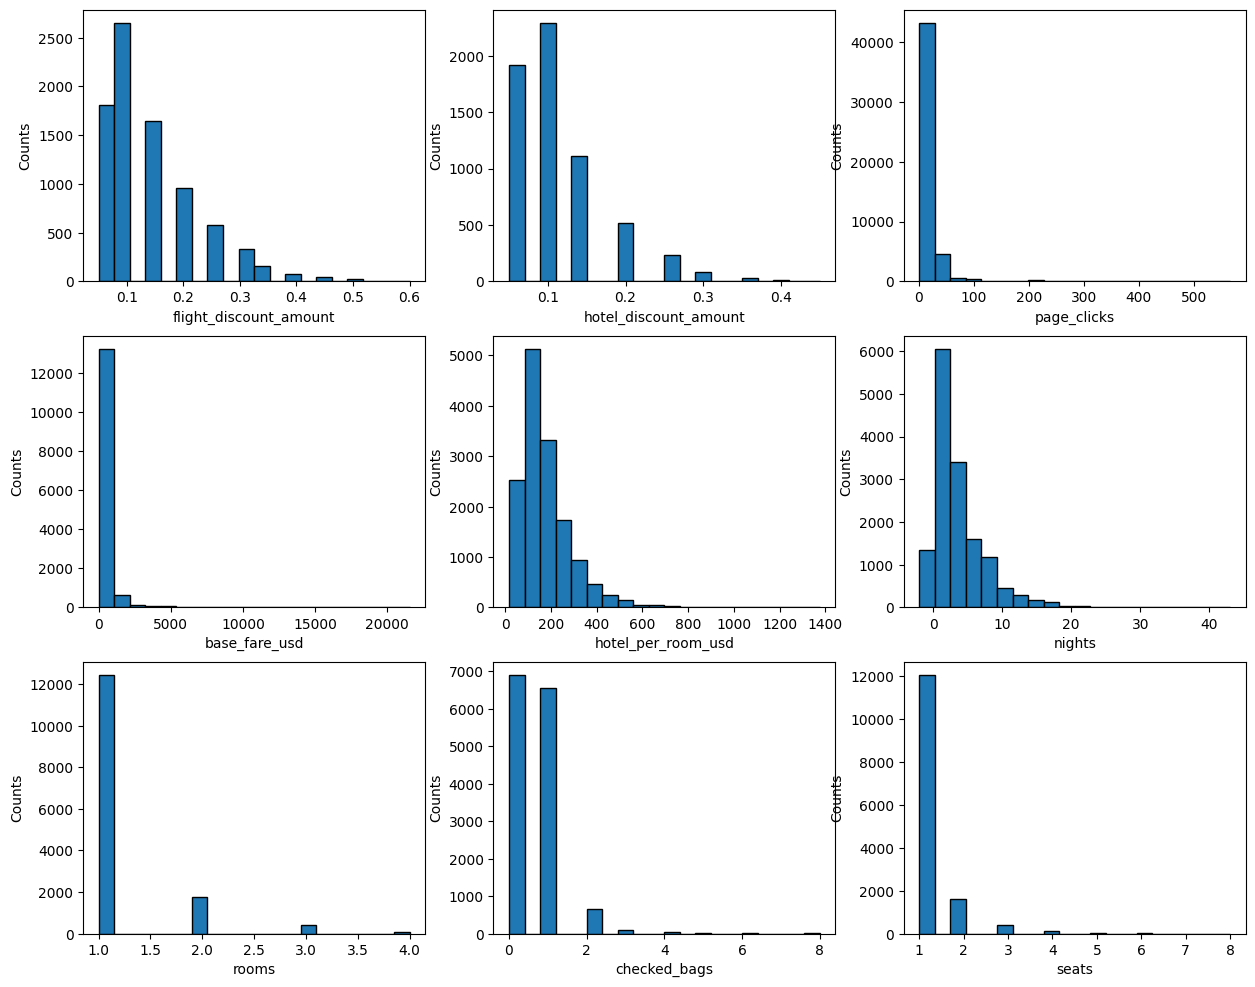

In [36]:
numerical_cols = ['flight_discount_amount', 'hotel_discount_amount', 'page_clicks', 'base_fare_usd', 'hotel_per_room_usd', 'nights', 'rooms', 'checked_bags', 'seats']


fig, axs = plt.subplots(3, 3, figsize=(15, 12))
axs = axs.flatten()

# Plot histograms for each column
for i, col in enumerate(numerical_cols):
    axs[i].hist(df_sessions_base[col], bins=20, edgecolor='black')
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Counts')

Clearly there are some outliers in the numerical data as the histograms as skewed.

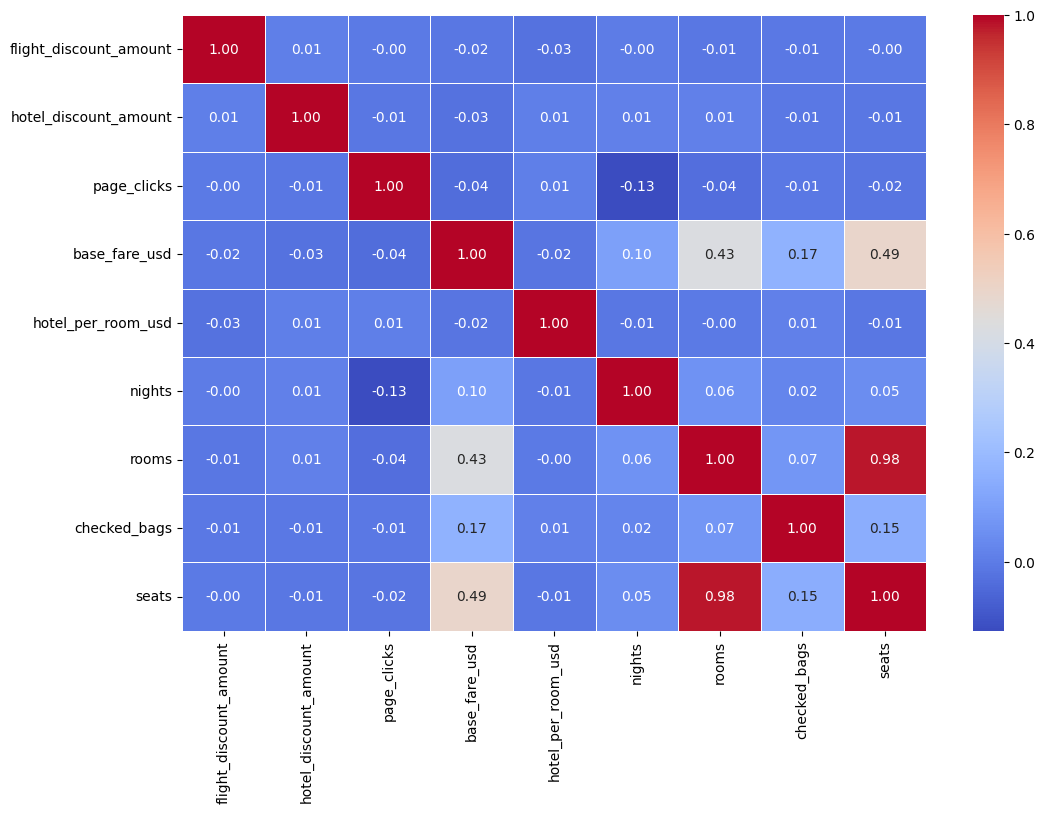

In [37]:
corr_matrix = df_booked_trips[numerical_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f",linewidths=0.5)
plt.show()

No unusual correlation noticed. Rooms and seats are highly correlated. This is acceptable as more people travelling will need more rooms.

# Data cleaning

In [38]:
# Find out how many -ve nigh values are there in the dataset
neg_nights = df_booked_trips[df_booked_trips['nights'] < 0]['nights'].value_counts()
print(neg_nights)

nights
-1.0    102
-2.0      1
Name: count, dtype: int64


In [39]:
# Convert the -ve values to +ve
df_booked_trips["nights"] = df_booked_trips["nights"].abs()

<ipython-input-39-5950169dda5b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_booked_trips["nights"] = df_booked_trips["nights"].abs()


Since the number of -ve nights are very low, we are assuming that this is a data error. So, we are converting these -ve values to +ve values.

In [40]:
# Checking if the data is now +ve
df_booked_trips[df_booked_trips['nights'] < 0]['nights'].value_counts()

,count
nights,


In [41]:
# Check null values
df_booked_trips.isna().sum()

,0
session_id,0
user_id,0
birthdate,0
gender,0
married,0
has_children,0
home_country,0
home_city,0
home_airport,0
home_airport_lat,0


In [42]:
df_booked_trips = df_booked_trips.dropna(subset=['flight_discount_amount'])

The null values can be dropped aas the % with total data is very low (<10%)

In [43]:
# Check if null values are removed.
df_booked_trips.isna().sum()

,0
session_id,0
user_id,0
birthdate,0
gender,0
married,0
has_children,0
home_country,0
home_city,0
home_airport,0
home_airport_lat,0


# Feature Engineering

In [44]:
bool_columns = df_booked_trips.select_dtypes(include='bool').columns.tolist()
#df_sessions.select_dtypes('bool')
bool_columns.append('return_flight_booked')
bool_columns

['married',
 'has_children',
 'flight_discount',
 'hotel_discount',
 'flight_booked',
 'hotel_booked',
 'cancellation',
 'return_flight_booked']

In [45]:
#Changing the True & False values to 1 & 0 for applying Machine Learning
df_booked_trips[bool_columns] = df_booked_trips[bool_columns].fillna(0)

for bool_column in bool_columns:
  df_booked_trips[bool_column] = df_booked_trips[bool_column].astype(int)

df_booked_trips.head(10)

<ipython-input-45-1064f8e245f3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_booked_trips[bool_columns] = df_booked_trips[bool_columns].fillna(0)
<ipython-input-45-1064f8e245f3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_booked_trips[bool_column] = df_booked_trips[bool_column].astype(int)
<ipython-input-45-1064f8e245f3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

,session_id,user_id,birthdate,gender,married,has_children,home_country,home_city,home_airport,home_airport_lat,...,destination_airport_lat,destination_airport_lon,base_fare_usd,hotel_name,hotel_location,nights,rooms,check_in_time,check_out_time,hotel_per_room_usd
10,551685-f00daef39aae4855bdf1d5c57548d728,551685,1957-07-19,M,1,0,usa,san antonio,RND,29.529,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,613383-14d1c0ca4c984d47b43e2c4e1395482b,613383,1985-09-06,M,0,0,usa,phoenix,PHX,33.434,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,617506-3cefba5f09be4faea332c1b5c8cf3318,617506,1979-12-02,F,1,0,canada,halifax,YHZ,44.881,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,511568-0bb3473c26714e479c94c8159612641c,511568,2003-04-04,F,0,0,usa,baltimore,BWI,39.175,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,539912-30bbb6e33bab4f0084fa87147ee45e0d,539912,1968-02-17,F,1,0,usa,fresno,FAT,36.776,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,581858-9630ecd0692a491d8234828a0ff94b7b,581858,1976-12-04,F,1,0,usa,los angeles,LAX,33.942,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,506186-2b1924a4f1c249eca4045ef4b46183f6,506186,1998-06-17,F,0,0,usa,detroit,DTW,42.212,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47,551210-6974fdf1a34441fa9ef22892be65ea19,551210,2006-10-21,F,0,1,usa,newport news,PHF,37.132,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53,612220-1ab0b9ebd394411e86ec443c6c6c7f41,612220,2006-10-12,M,0,0,usa,lubbock,LBB,33.664,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56,621849-b6ce57291ac840f694ec6fda0ba43231,621849,1971-06-15,F,1,1,usa,birmingham,BHM,33.563,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
df_booked_trips.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8189 entries, 10 to 49209
Data columns (total 42 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   session_id               8189 non-null   object 
 1   user_id                  8189 non-null   int64  
 2   birthdate                8189 non-null   object 
 3   gender                   8189 non-null   object 
 4   married                  8189 non-null   int64  
 5   has_children             8189 non-null   int64  
 6   home_country             8189 non-null   object 
 7   home_city                8189 non-null   object 
 8   home_airport             8189 non-null   object 
 9   home_airport_lat         8189 non-null   float64
 10  home_airport_lon         8189 non-null   float64
 11  sign_up_date             8189 non-null   object 
 12  trip_id                  2309 non-null   object 
 13  session_start            8189 non-null   object 
 14  session_end              81

In [47]:
df_booked_trips['home_country'].value_counts()

,count
home_country,
usa,6842
canada,1347


In [48]:
# Load airport data
airports = airportsdata.load("IATA")  # Load IATA airport data

# Function to get country from airport code
def get_country(airport_code):
    if pd.notnull(airport_code) and airport_code in airports:
        return airports[airport_code]['country']
    return np.nan

# Add home and destination country
df_booked_trips['source_country'] = df_booked_trips['home_airport'].apply(get_country)
df_booked_trips['destination_country'] = df_booked_trips['destination_airport'].apply(get_country)

# Function to classify trip type
def classify_trip(row):
    if pd.notnull(row['source_country']) and pd.notnull(row['destination_country']):
        return "Domestic" if row['source_country'].lower() == row['destination_country'].lower() else "International"
    return np.nan

# Apply trip classification
df_booked_trips['trip_type'] = df_booked_trips.apply(classify_trip, axis=1)

# Convert necessary date columns to datetime
date_cols = ['session_start', 'session_end', 'sign_up_date', 'departure_time', 'check_in_time', 'return_time', 'birthdate']
for col in date_cols:
    df_booked_trips[col] = pd.to_datetime(df_booked_trips[col], errors='coerce')

current_date = datetime.now()

# Function to calculate Haversine distance
def calculate_haversine(row):
    if pd.notnull(row['home_airport_lat']) and pd.notnull(row['destination_airport_lat']):
        origin = (row['home_airport_lat'], row['home_airport_lon'])
        destination = (row['destination_airport_lat'], row['destination_airport_lon'])
        return haversine(origin, destination, unit=Unit.KILOMETERS)  # Distance in KM
    return np.nan

# Apply the Haversine formula for each trip
df_booked_trips['flight_distance_km'] = df_booked_trips.apply(calculate_haversine, axis=1)


In [49]:
# Aggregation at user_id level
df_user_features = df_booked_trips.groupby('user_id').agg(

    # ++++ User attributes ++++
    gender = ('gender', 'first'),
    married = ('married', 'first'),
    has_children = ('has_children', 'first'),
    home_country = ('home_country', 'first'),
    #home_city = ('home_city', 'first'),
    sign_up_date = ('sign_up_date', 'first'),
    age = ('birthdate', lambda x: (current_date - x.max()).days // 365),  # Age from birthdate

    # ++++ User browsing pattern ++++

    total_sessions = ('session_id', 'count'),
    #total_page_clicks=('page_clicks', 'sum'),
    total_page_clicks = ('page_clicks', 'sum'),
    #total_session_time=('session_end', lambda x: (x.max() - x.min()).total_seconds()),  # Time spent across sessions
    avg_session_duration = ('session_end', lambda x: (x - df_booked_trips.loc[x.index, 'session_start']).dt.total_seconds().mean()),
    #first_session_date=('session_start', 'min'),
    last_session_date=('session_start', 'max'),
    #days_since_last_session = ('session_start', lambda x: (current_date - x.max()).days),
    #browsed_airlines = ('trip_airline', 'nunique'),
    #browsed_hotels = ('hotel_name', 'nunique'),
    #browsed_destinations = ('destination_airport', 'nunique'),



    # ++++ User booking pattern ++++

    total_trips = ('trip_id', 'count'),
    total_flights_booked = ('flight_booked', 'sum'),
    total_hotels_booked = ('hotel_booked', 'sum'),
    total_spent_flights = ('base_fare_usd', 'sum'),
    total_spent_hotels = ('hotel_per_room_usd', lambda x: (x * df_booked_trips.loc[x.index, 'nights']).sum()),
    #avg_flight_spending = ('base_fare_usd', 'mean'),
    #avg_hotel_spending = ('hotel_per_room_usd', 'mean'),
    discount_used_flight = ('flight_discount_amount', lambda x: (x > 0).sum()),
    discount_used_hotel = ('hotel_discount_amount', lambda x: (x > 0).sum()),
    #most_used_airline=('trip_airline', lambda x: x.mode()[0] if not x.mode().empty else np.nan),
    #favourite_destination=('destination_country', lambda x: x.mode()[0] if not x.mode().empty else np.nan),
    avg_seats_booked=('seats', 'mean'),
    avg_checked_bags=('checked_bags', 'mean'),
    return_flights=('return_flight_booked', lambda x: x.notnull().sum()),
    avg_days_to_departure=('departure_time', lambda x: (x - df_booked_trips.loc[x.index, 'session_end']).dt.days.mean()),
    avg_days_to_check_in=('check_in_time', lambda x: (x - df_booked_trips.loc[x.index, 'session_end']).dt.days.mean()),
    avg_flight_distance=('flight_distance_km', 'mean'),  # Average distance flown
    domestic_trips=('trip_type', lambda x: (x == "Domestic").sum()),
    international_trips=('trip_type', lambda x: (x == "International").sum()),
)



# Additional derived features
df_user_features['total_spent'] = df_user_features['total_spent_flights'] + df_user_features['total_spent_hotels']
df_user_features['booking_frequency'] = df_user_features['total_flights_booked'] + df_user_features['total_hotels_booked']
df_user_features['avg_spent_per_booking'] = df_user_features['total_spent'] / df_user_features['booking_frequency']
df_user_features['session_recency'] = (current_date - df_user_features['last_session_date']).dt.days

# Drop redundant date columns after computation
df_user_features = df_user_features.drop(columns=['last_session_date', 'sign_up_date'])

# Reset index to make user_id a column
df_user_features.reset_index(inplace=True)

# Final cleaned DataFrame with engineered features
df_user_features.head()

,user_id,gender,married,has_children,home_country,age,total_sessions,total_page_clicks,avg_session_duration,total_trips,...,return_flights,avg_days_to_departure,avg_days_to_check_in,avg_flight_distance,domestic_trips,international_trips,total_spent,booking_frequency,avg_spent_per_booking,session_recency
0,101486,F,1,1,usa,52,2,34,126.0,0,...,2,NaN,NaN,NaN,0,0,0.00,0,NaN,627
1,101961,F,1,0,usa,44,2,29,108.5,1,...,2,10.0,10.0,300.162537,1,0,544.67,2,272.335,663
2,118043,F,0,1,usa,52,2,23,85.5,1,...,2,NaN,NaN,NaN,0,0,1416.00,1,1416.000,582
3,120851,F,1,1,usa,52,2,9,34.0,0,...,2,NaN,NaN,NaN,0,0,0.00,0,NaN,730
4,125845,F,1,0,usa,41,1,29,219.0,1,...,1,10.0,10.0,2005.864354,1,0,906.38,2,453.190,745


In [50]:
df_user_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4645 entries, 0 to 4644
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                4645 non-null   int64  
 1   gender                 4645 non-null   object 
 2   married                4645 non-null   int64  
 3   has_children           4645 non-null   int64  
 4   home_country           4645 non-null   object 
 5   age                    4645 non-null   int64  
 6   total_sessions         4645 non-null   int64  
 7   total_page_clicks      4645 non-null   int64  
 8   avg_session_duration   4645 non-null   float64
 9   total_trips            4645 non-null   int64  
 10  total_flights_booked   4645 non-null   int64  
 11  total_hotels_booked    4645 non-null   int64  
 12  total_spent_flights    4645 non-null   float64
 13  total_spent_hotels     4645 non-null   float64
 14  discount_used_flight   4645 non-null   int64  
 15  disc

In [51]:
final_features = df_user_features[['user_id', 'gender', 'has_children',
                                   'age', 'total_trips', 'total_spent_flights',
                                   'total_spent_hotels', 'avg_checked_bags',
                                   'avg_flight_distance', 'domestic_trips',
                                   'international_trips', 'booking_frequency',
                                   'session_recency']]

final_features = final_features.set_index('user_id')
final_features.head()

,gender,has_children,age,total_trips,total_spent_flights,total_spent_hotels,avg_checked_bags,avg_flight_distance,domestic_trips,international_trips,booking_frequency,session_recency
user_id,,,,,,,,,,,,
101486,F,1,52,0,0.00,0.0,NaN,NaN,0,0,0,627
101961,F,0,44,1,49.67,495.0,0.0,300.162537,1,0,2,663
118043,F,1,52,1,0.00,1416.0,NaN,NaN,0,0,1,582
120851,F,1,52,0,0.00,0.0,NaN,NaN,0,0,0,730
125845,F,0,41,1,710.38,196.0,1.0,2005.864354,1,0,2,745


In [52]:
final_features.shape

(4645, 12)

In [53]:
final_features['gender'].value_counts()

,count
gender,
F,4108
M,529
O,8


In [54]:
gender_map = {'F': 0,
              'M': 1,
              'O': 0}

final_features['gender'] = final_features['gender'].map(gender_map)

In [55]:
final_features['gender'].value_counts()

,count
gender,
0,4116
1,529


In [56]:
final_features.head()

,gender,has_children,age,total_trips,total_spent_flights,total_spent_hotels,avg_checked_bags,avg_flight_distance,domestic_trips,international_trips,booking_frequency,session_recency
user_id,,,,,,,,,,,,
101486,0,1,52,0,0.00,0.0,NaN,NaN,0,0,0,627
101961,0,0,44,1,49.67,495.0,0.0,300.162537,1,0,2,663
118043,0,1,52,1,0.00,1416.0,NaN,NaN,0,0,1,582
120851,0,1,52,0,0.00,0.0,NaN,NaN,0,0,0,730
125845,0,0,41,1,710.38,196.0,1.0,2005.864354,1,0,2,745


In [57]:
final_features.isna().sum()

,0
gender,0
has_children,0
age,0
total_trips,0
total_spent_flights,0
total_spent_hotels,0
avg_checked_bags,2995
avg_flight_distance,2995
domestic_trips,0
international_trips,0


In [58]:
final_features = final_features.fillna(0)

In [59]:
final_features.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4645.0,0.113886,0.317707,0.0,0.0,0.0,0.000000,1.000000
has_children,4645.0,0.327018,0.469175,0.0,0.0,0.0,1.000000,1.000000
age,4645.0,42.418084,11.923277,18.0,35.0,43.0,50.000000,89.000000
total_trips,4645.0,0.497094,0.643528,0.0,0.0,0.0,1.000000,4.000000
total_spent_flights,4645.0,189.933772,477.656123,0.0,0.0,0.0,264.940000,14474.350000
total_spent_hotels,4645.0,290.859419,696.180140,0.0,0.0,0.0,265.000000,7790.000000
avg_checked_bags,4645.0,0.202655,0.464624,0.0,0.0,0.0,0.000000,4.000000
avg_flight_distance,4645.0,777.286175,1348.135632,0.0,0.0,0.0,1334.498122,14432.209449
domestic_trips,4645.0,0.255974,0.490795,0.0,0.0,0.0,0.000000,3.000000
international_trips,4645.0,0.128741,0.353100,0.0,0.0,0.0,0.000000,2.000000


In [60]:
final_features.shape

(4645, 12)

# Clustering

In [61]:
# Scaled the user features for ML
scaler = StandardScaler()
feature_scaled = scaler.fit_transform(final_features)

In [62]:
feature_scaled.shape

(4645, 12)

In [63]:
feature_scaled = pd.DataFrame(feature_scaled)
feature_scaled.index = final_features.index
feature_scaled.columns = final_features.columns
feature_scaled.shape

(4645, 12)

In [64]:
feature_scaled.head()

,gender,has_children,age,total_trips,total_spent_flights,total_spent_hotels,avg_checked_bags,avg_flight_distance,domestic_trips,international_trips,booking_frequency,session_recency
user_id,,,,,,,,,,,,
101486,-0.358501,1.434550,0.803718,-0.772534,-0.397680,-0.417838,-0.436217,-0.576626,-0.521606,-0.36464,-0.742168,-0.930596
101961,-0.358501,-0.697083,0.132689,0.781568,-0.293682,0.293261,-0.436217,-0.353952,1.516123,-0.36464,0.996293,-0.281411
118043,-0.358501,1.434550,0.803718,0.781568,-0.397680,1.616337,-0.436217,-0.576626,-0.521606,-0.36464,0.127063,-1.742077
120851,-0.358501,1.434550,0.803718,-0.772534,-0.397680,-0.417838,-0.436217,-0.576626,-0.521606,-0.36464,-0.742168,0.926795
125845,-0.358501,-0.697083,-0.118947,0.781568,1.089701,-0.136272,1.716292,0.911415,1.516123,-0.36464,0.996293,1.197289


In [65]:
feature_scaled.isna().sum()

,0
gender,0
has_children,0
age,0
total_trips,0
total_spent_flights,0
total_spent_hotels,0
avg_checked_bags,0
avg_flight_distance,0
domestic_trips,0
international_trips,0


In [66]:
feature_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4645.0,-2.447510e-17,1.000108,-0.358501,-0.358501,-0.358501,-0.358501,2.789394
has_children,4645.0,-1.300240e-17,1.000108,-0.697083,-0.697083,-0.697083,1.434550,1.434550
age,4645.0,-4.589081e-17,1.000108,-2.048154,-0.622218,0.048810,0.635960,3.907225
total_trips,4645.0,-7.495499e-17,1.000108,-0.772534,-0.772534,-0.772534,0.781568,5.443873
total_spent_flights,4645.0,-4.589081e-17,1.000108,-0.397680,-0.397680,-0.397680,0.157047,29.908450
total_spent_hotels,4645.0,6.271744e-17,1.000108,-0.417838,-0.417838,-0.417838,-0.037149,10.772999
avg_checked_bags,4645.0,4.589081e-17,1.000108,-0.436217,-0.436217,-0.436217,-0.436217,8.173822
avg_flight_distance,4645.0,2.753449e-17,1.000108,-0.576626,-0.576626,-0.576626,0.413365,10.129836
domestic_trips,4645.0,-6.118775e-18,1.000108,-0.521606,-0.521606,-0.521606,-0.521606,5.591580
international_trips,4645.0,8.757497e-17,1.000108,-0.364640,-0.364640,-0.364640,-0.364640,5.300083


In [67]:
# Dimensionality reduction using PCA

pca = PCA(n_components = 0.7)
pca.fit(feature_scaled)

component_matrix = pd.DataFrame(pca.components_).T
component_matrix.columns = [f"pca_{i}"for i in range(component_matrix.shape[1])]
component_matrix.index = feature_scaled.columns
component_matrix

,pca_0,pca_1,pca_2,pca_3,pca_4
gender,0.015800,0.157726,-0.431205,-0.116310,0.466307
has_children,-0.000814,0.272721,-0.288552,0.033456,0.656799
age,0.043474,0.014170,-0.104280,0.927535,-0.049654
total_trips,0.436501,-0.186365,0.099440,-0.041189,0.122251
total_spent_flights,0.347913,0.304787,-0.153370,-0.030979,-0.186895
total_spent_hotels,0.232345,-0.319430,0.447101,-0.085332,0.352823
avg_checked_bags,0.305836,0.137450,-0.194010,-0.000387,-0.180614
avg_flight_distance,0.391043,0.246823,-0.135438,-0.021117,-0.184665
domestic_trips,0.329864,-0.476432,-0.405781,-0.024152,-0.075851
international_trips,0.250967,0.572463,0.454584,0.004753,0.041715


<Axes: >

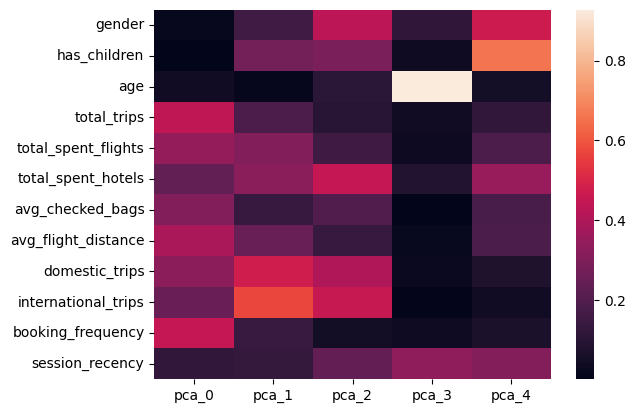

In [68]:
sns.heatmap(np.abs(component_matrix))

In [69]:
customers_pca = pca.fit_transform(feature_scaled)
customers_pca

array([[-1.38547565,  0.32437388, -0.14807076,  1.27650101,  1.01622834],
       [ 0.92352516, -1.82839484,  0.0598271 ,  0.12261892, -0.21091497],
       [ 0.25205248, -0.84179517,  1.14951568,  1.28136839,  2.2324273 ],
       ...,
       [ 1.28662059,  1.42709696,  1.57905869,  1.65520789,  1.65713374],
       [-1.39860425,  0.3079551 , -0.07832632,  0.83392922,  1.06354079],
       [-1.42034023,  0.76902419, -1.22601921, -1.21957969,  2.64537633]])

In [70]:
customers_pca = pd.DataFrame(customers_pca)
customers_pca.index = feature_scaled.index
customers_pca.columns = [f"pca_{i}"for i in range(customers_pca.shape[1])]
customers_pca

,pca_0,pca_1,pca_2,pca_3,pca_4
user_id,,,,,
101486,-1.385476,0.324374,-0.148071,1.276501,1.016228
101961,0.923525,-1.828395,0.059827,0.122619,-0.210915
118043,0.252052,-0.841795,1.149516,1.281368,2.232427
120851,-1.610801,0.563531,-0.592595,0.652573,0.441408
125845,2.267825,-0.474537,-1.261027,-0.641258,-1.688582
...,...,...,...,...,...
785186,-1.400063,0.304445,-0.065264,0.762186,1.073286
792549,-1.336345,-0.332567,0.640223,0.997909,-0.195578
801660,1.286621,1.427097,1.579059,1.655208,1.657134


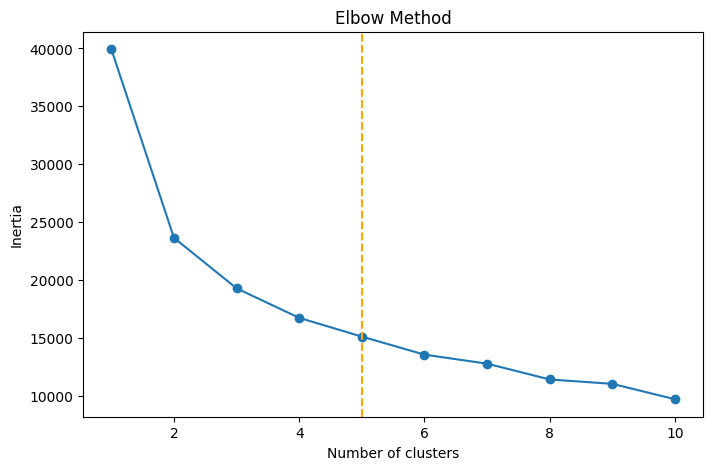

In [71]:
# Determine the optimal number of clusters using the Elbow Method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customers_pca)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')


# Add a reference line to help identify the elbow point
plt.axvline(x=5, color='orange', linestyle='--', label='Elbow Point')

plt.show()

In [72]:
# Choose the optimal number of clusters (e.g., 4)
optimal_k = 5

# Perform K-Means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
final_features['cluster'] = kmeans.fit_predict(customers_pca)

In [73]:
# Check the model score

sil_score = silhouette_score(customers_pca, final_features['cluster'] )  # Measure clustering quality
print(f"Silhouette Score: {sil_score}")

Silhouette Score: 0.33033418225903277


In [74]:
final_features['cluster'].value_counts()

,count
cluster,
1,1766
3,1201
2,910
0,506
4,262


In [75]:
customers_viz = pd.concat([customers_pca,final_features['cluster']],axis=1)
customers_viz

,pca_0,pca_1,pca_2,pca_3,pca_4,cluster
user_id,,,,,,
101486,-1.385476,0.324374,-0.148071,1.276501,1.016228,3
101961,0.923525,-1.828395,0.059827,0.122619,-0.210915,2
118043,0.252052,-0.841795,1.149516,1.281368,2.232427,3
120851,-1.610801,0.563531,-0.592595,0.652573,0.441408,3
125845,2.267825,-0.474537,-1.261027,-0.641258,-1.688582,2
...,...,...,...,...,...,...
785186,-1.400063,0.304445,-0.065264,0.762186,1.073286,3
792549,-1.336345,-0.332567,0.640223,0.997909,-0.195578,1
801660,1.286621,1.427097,1.579059,1.655208,1.657134,0


<Axes: xlabel='pca_0', ylabel='pca_1'>

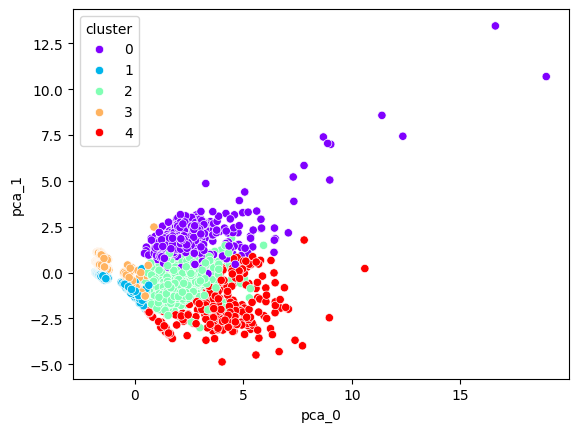

In [76]:
sns.scatterplot(data=customers_viz,x="pca_0",y="pca_1",hue=final_features['cluster'],palette="rainbow",legend='full')

In [77]:
# Analyze clusters by computing average values
cluster_analysis = final_features.groupby('cluster').mean()
cluster_analysis

,gender,has_children,age,total_trips,total_spent_flights,total_spent_hotels,avg_checked_bags,avg_flight_distance,domestic_trips,international_trips,booking_frequency,session_recency
cluster,,,,,,,,,,,,
0,0.114625,0.353755,43.515810,1.148221,645.411324,499.503953,0.590580,2496.729763,0.045455,1.047431,2.120553,666.958498
1,0.000000,0.000000,42.033409,0.087203,0.517322,88.774066,0.000000,2.986763,0.000000,0.000000,0.090034,686.078143
2,0.126374,0.312088,43.700000,1.029670,434.846022,327.684615,0.571429,2073.451353,0.942857,0.000000,1.898901,672.493407
3,0.273106,0.821815,41.353872,0.109076,1.428093,106.330558,0.000000,6.706362,0.000833,0.000833,0.113239,684.898418
4,0.106870,0.263359,43.316794,1.931298,600.479504,1968.022901,0.467557,1706.027963,1.171756,0.255725,3.320611,643.110687


# Perk Recommendation to clusters

In [78]:
def assign_cluster_perks(cluster_row):
    perks = []

    # Free Cancellation : International travelers face more uncertainty, so "Free Cancellation" is a useful perk.
    # But it is good to offer them to inactive users, so that they start booking more.
    if cluster_row['international_trips'] > 0.9 and cluster_row['session_recency'] > 700:
        return("Free Cancellation")

    # Free child ticket : If most users are over 30 and have children
    elif cluster_row['age'] > 40 and cluster_row['has_children'] > 0.5:
        return("Free child ticket")

    # Exclusive Discounts : These are customers with high booking frequency. Frequent travelers are loyal, so offering "Exclusive Discounts" encourages continued loyalty.
    elif cluster_row['booking_frequency'] > 3 :
        return("Exclusive Discounts")

    # Free checked bags : These customers travel internationally and frequently check bags.
    elif cluster_row['avg_checked_bags'] > 0.5 and cluster_row['international_trips'] > 0.9:
        return("Free checked bags")

    # 1-night free :  These customers spend a lot on flights but not on hotels,so offering "One Night Free Hotel With Flight" perk can make them to book more hotels.
    elif cluster_row['total_spent_flights'] > 400 and cluster_row['total_spent_hotels'] < 400 :
        return("One Night Free Hotel With Flight")

    # 10% off next trip : For customers who do not fit any of the above conditions, a one time 10% off next trip can be offered
    else:
      return ("10% off next trip")

# Assign perks to each cluster
cluster_analysis['perks'] = cluster_analysis.apply(assign_cluster_perks, axis=1)

cluster_analysis

,gender,has_children,age,total_trips,total_spent_flights,total_spent_hotels,avg_checked_bags,avg_flight_distance,domestic_trips,international_trips,booking_frequency,session_recency,perks
cluster,,,,,,,,,,,,,
0,0.114625,0.353755,43.515810,1.148221,645.411324,499.503953,0.590580,2496.729763,0.045455,1.047431,2.120553,666.958498,Free checked bags
1,0.000000,0.000000,42.033409,0.087203,0.517322,88.774066,0.000000,2.986763,0.000000,0.000000,0.090034,686.078143,10% off next trip
2,0.126374,0.312088,43.700000,1.029670,434.846022,327.684615,0.571429,2073.451353,0.942857,0.000000,1.898901,672.493407,One Night Free Hotel With Flight
3,0.273106,0.821815,41.353872,0.109076,1.428093,106.330558,0.000000,6.706362,0.000833,0.000833,0.113239,684.898418,Free child ticket
4,0.106870,0.263359,43.316794,1.931298,600.479504,1968.022901,0.467557,1706.027963,1.171756,0.255725,3.320611,643.110687,Exclusive Discounts


In [79]:
# Merge cluster perks into the main user dataframe
final_features = final_features.merge(cluster_analysis[['perks']], left_on='cluster', right_index=True, how='left')
final_features = final_features.reset_index()
final_features.head(10)

,user_id,gender,has_children,age,total_trips,total_spent_flights,total_spent_hotels,avg_checked_bags,avg_flight_distance,domestic_trips,international_trips,booking_frequency,session_recency,cluster,perks
0,101486,0,1,52,0,0.00,0.0,0.0,0.000000,0,0,0,627,3,Free child ticket
1,101961,0,0,44,1,49.67,495.0,0.0,300.162537,1,0,2,663,2,One Night Free Hotel With Flight
2,118043,0,1,52,1,0.00,1416.0,0.0,0.000000,0,0,1,582,3,Free child ticket
3,120851,0,1,52,0,0.00,0.0,0.0,0.000000,0,0,0,730,3,Free child ticket
4,125845,0,0,41,1,710.38,196.0,1.0,2005.864354,1,0,2,745,2,One Night Free Hotel With Flight
5,149058,0,1,52,1,190.55,357.0,0.0,1096.070168,1,0,2,672,2,One Night Free Hotel With Flight
6,152583,0,0,38,0,0.00,0.0,0.0,0.000000,0,0,0,739,1,10% off next trip
7,164522,0,0,49,1,328.32,3029.0,1.0,1786.075629,1,0,2,738,4,Exclusive Discounts
8,167852,0,0,19,0,0.00,0.0,0.0,0.000000,0,0,0,771,1,10% off next trip
9,175032,0,0,30,0,0.00,0.0,0.0,0.000000,0,0,0,625,1,10% off next trip


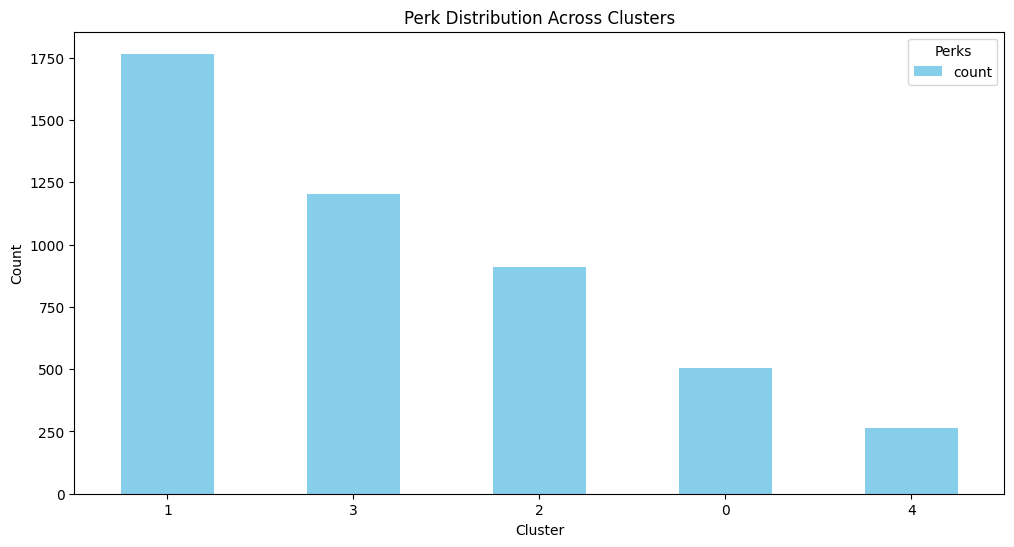

In [80]:
cluster_distribution = final_features['cluster'].value_counts()
# Plot stacked bar chart
cluster_distribution.plot(kind='bar', stacked=True, figsize=(12, 6), color='skyblue')

# Add labels and title
plt.title("Perk Distribution Across Clusters")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.legend(title="Perks", bbox_to_anchor=(1, 1))  # Move legend outside
plt.xticks(rotation=0)
plt.show()

In [81]:
# Display cluster-wise perk distribution
perks_distribution = final_features.groupby('cluster')['perks'].value_counts()
perks_distribution

,,count
cluster,perks,
0,Free checked bags,506
1,10% off next trip,1766
2,One Night Free Hotel With Flight,910
3,Free child ticket,1201
4,Exclusive Discounts,262


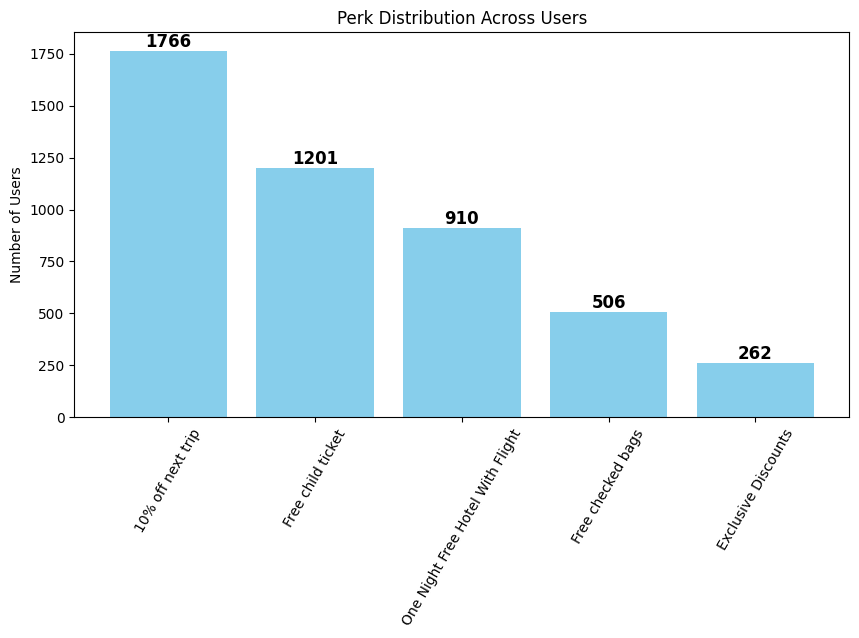

In [82]:
# Visualize the perks distribution across users
perk_counts = final_features['perks'].value_counts()

plt.figure(figsize=(10, 5))
bars = plt.bar(perk_counts.index, perk_counts.values, color='skyblue')

for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2,   # X position (center of bar)
             bar.get_height(),                    # Y position (top of bar)
             int(bar.get_height()),               # Text (value count)
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title("Perk Distribution Across Users")
plt.ylabel("Number of Users")
plt.xticks(rotation=60)  # Rotate x-axis labels if needed
plt.show()

In [83]:
# Save the final dataset with perks
final_features.to_csv('travel_tide_dataset_with_perks.csv', index=False)